This is a widget-heavy notebook that uses the nomenclature in [1] to design airfoils and analyze them.
You can analyze the vast array of airfoils in [1] by simply pasting the code of the airfoil below.

[1] Melin, T. (2013). *Parametric Airfoil Catalog: An Aerodynamic and Geometric Comparison Between Parametrized and Point Cloud Airfoils - Part 1 and 2*. [Link](https://www.researchgate.net/publication/320930333_Parametric_Airfoil_Catalog_Part_I_II_An_Aerodynamic_and_Geometric_Comparison_Between_Parametrized_and_Point_Cloud_Airfoils) 

In [2]:
# Default to read. After running this cell this is loaded.
# Airfoil codes can be found in [1]
Airfoil = "K2ZW_awNMSkkS6I"


# Plot nice and large
%matplotlib inline
#%matplotlib notebook
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Import airfoil designer modules
from af_bezier import * 
from af_ui import * 
from af_pac import * 
from af_analysis import * 

kparam = B64read(Airfoil)

# Import some widgets
import ipywidgets as widgets
from ipywidgets import interactive, interact
from ipywidgets import FloatSlider
matplotlib.rcParams['figure.figsize'] = [12, 6] # Make plots bigger than default


# "global" variables, i.e. those that I want to use from within the widget-functions. Probably not the intended way.
X = []
P = []
SR = []


# k1 to k15 are the parameters as in [1]
ParNames = ["Nose Thck","Lead Point","Mid Point","Trail Point","Thickness",
           "Nose Thck","Lead Point","Mid Point","Trail Point","Thickness",
           "Top Len","Bottom Len","Angle Legs","Angle TE","Gap"]
ks = []
for k in range(len(ParNames)):
    ks.append(FloatSlider(value = kparam[k], min=0, max=1, step=0.01, 
                          continuous_update=False,description=ParNames[k]))

# Widget function
def manipulateAirfoil(k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,N,LEFAC,TEFAC,KAPFAC,
                      REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1,REFVAL):
    
    # Airfoil Coordinates
    global P # Set of Bezier Points
    global kparam # k1 to k15
    ax=[]
    for kp in range(15):
        kparam[kp] = eval("k%u"%(kp+1))
    P = foilPoints(kparam)
    ds = 0.002
    (T,ArcPoints,Curvature) = pointsByArcLength(P,np.arange(0,1+ds,ds))
    (S,_,_) = getLength(P)
    
    # Airfoil Discretization
    global X # Airfoil coordinates
    global SR # Arclength discretization

    (X,SR) = repanelArclength(ArcPoints[:,::-1],int(N),LEFAC,TEFAC,KAPFAC,
                              [REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1],REFVAL)

    bezierPlot(ax,P);
    plt.plot(X[0,:],X[1,:],"+",color="#AAAAAA")
    plt.plot(X[0,:],X[1,:],"-k")
    plt.axis('equal')
    
    print("Airfoil Code:" + B64write(kparam))


paramtop = widgets.VBox([widgets.HTML(value="<u>Top Side Parameter</u>"),*ks[0:5]])
parambottom = widgets.VBox([widgets.HTML(value="<u>Bottom Side Parameter</u>"),*ks[5:10]])
paramte = widgets.VBox([widgets.HTML(value="<u>Trailing Edge Parameter</u>"),*ks[11:15]])

paramdisc = widgets.HBox([widgets.VBox([widgets.HTML(value="<u>Weights</u>"),
                                        N,KAPFAC,LEFAC,TEFAC,REFVAL]),
                          widgets.VBox([widgets.HTML(value="<u>Refinement</u>"),
                                        REFTOPX0,REFTOPX1,REFBOTX0,REFBOTX1])])
paramfoil = widgets.HBox([paramtop, parambottom,paramte])

ui = widgets.VBox([widgets.HTML(value="<b>Airfoil Parameters</b>"),paramfoil,
                   widgets.HTML(value="<b>Discretization Parameters</b>"),paramdisc])

# Very elegant.
out=widgets.interactive_output(manipulateAirfoil, {'k1':ks[0],'k2':ks[1],'k3':ks[2],'k4':ks[3],'k5':ks[4],
                                                'k6':ks[5],'k7':ks[6],'k8':ks[7],'k9':ks[8],'k10':ks[9],
                                                'k11':ks[10],'k12':ks[11],'k13':ks[12],'k14':ks[13],'k15':ks[14],
                                                'N':N,'LEFAC':LEFAC,'TEFAC':TEFAC,'KAPFAC':KAPFAC,
                                                'REFTOPX0':REFTOPX0,'REFTOPX1':REFTOPX1,
                                                'REFBOTX0':REFBOTX0,'REFBOTX1':REFBOTX1,
                                                'REFVAL':REFVAL})

display(ui, out)

Output()

In [3]:
# Save discretized airfoil points, if you want
Name = "GOE222"
savePoints('Airfoil.dat',X,Name)

Download by clicking link below.<br>
**The cell above that saves current airfoil must have been executed**.

__[Airfoil.dat](Airfoil.dat)__

In [3]:
# Calculate a polar
REV = [5e5,1e6]
NCRIT = 9
MACH = 0
pol = []
for RE in REV:
    (alv,clv,cdv,cmv,bl,p) = viiflowPolar(X,np.arange(-10,20,1),RE,NCRIT,MACH)
    pol.append({'AOA':alv,'CL':clv,'CD':cdv,'CM':cmv,'RE':RE})

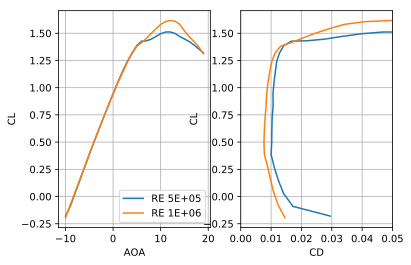

In [4]:
# Plot the polar
(fig,ax) = plt.subplots(1,2)
for k in range(len(pol)):
    ax[0].plot(pol[k]['AOA'],pol[k]['CL'],'-',label='RE %.E'%pol[k]['RE'])
    ax[1].plot(pol[k]['CD'],pol[k]['CL'],'-')
ax[0].legend()
ax[1].set_xlim(0,.05)
ax[0].grid(1)
ax[1].grid(1)
ax[0].set_xlabel('AOA')
ax[0].set_ylabel('CL')
ax[1].set_xlabel('CD')
ax[1].set_ylabel('CL');

In [6]:
# Save Polar data, if you want
Name = 'GOE222'
f = open('Polar.csv','w')
f.close()
f = open('Polar.csv','a')
for k in range(len(pol)):
    # Header
    header = "%s - RE %.E;;;\nAOA; CL; CD; CM"%(Name,pol[k]['RE'])
    X = np.c_[pol[k]['AOA'],pol[k]['CL'],pol[k]['CD'],pol[k]['CM']]
    np.savetxt(f, X, fmt='%1.8f; %1.8f; %1.8f; %1.8f', newline='\n', header=header,comments='')
f.close()

Download polar by clicking link below.<br>
**The cell above that saves current polar must have been executed**.

__[Polar.csv](Polar.csv)__